Test with radial bases function and make its variation through anistropic shape parameters and spherical harmonics
Here, the shape parameters are constructed with rotation and scale matrix!

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def rbf(x, kc, kcov):
    """
        Inputs:
            x: (h, w, d)
            kc: (1, 1, d)
            ks: (1, 1, d, d)
        Outputs:
            (..., k)
    """
    offset = x[..., :] - kc  # (n, d)
    out = 1 / (1 + ((offset[..., None] * kcov).sum(-2) * offset).sum(-1))
    return out, offset
    
def rbf_ch(x, kc, kcov, kch):
    """
        Inputs:
            x: (h, w, d)
            kc: (1, 1, d)
            kcov: (1, 1, d, d)
            kch: (1, 1, ch_d)
            ks: (1, 1, d, d)
        Outputs:
            (..., k)
    """
    offset = x[..., :] - kc  # (n, d)
    theta = np.arctan2(offset[..., 1], offset[..., 0])
    out = 1 / (1 + ((offset[..., None] * kcov).sum(-2) * offset).sum(-1))
    out = out * (1 + kch[..., 0] * np.cos(theta) + kch[...,1] * np.sin(theta))
    
    return out, offset
    
def rbf_ch_mod(x, kc, kcov, kch, ks):
    """
        Inputs:
            x: (h, w, d)
            kc: (1, 1, d)
            kcov: (1, 1, d, d)
            kch: (1, 1, ch_d)
            ks: (1, 1, d, d)
        Outputs:
            (..., k)
    """
    offset = x[..., :] - kc  # (n, d)
    theta = np.arctan2((offset[..., None] * ks).sum(-2)[..., 1], (offset[..., None] * ks).sum(-2)[..., 0])
    out = 1 / (1 + ((offset[..., None] * kcov).sum(-2) * offset).sum(-1))
    out = out * (1 + kch[..., 0] * np.cos(theta) + kch[...,1] * np.sin(theta))
    
    return out, offset

def get_scale_matrix(s1, s2):
    return np.array([[s1, 0],[0, s2]])

def get_rot_matrix(th):
    th = th / 180 * np.pi
    return np.array([[np.cos(th), -np.sin(th)],
                     [np.sin(th), np.cos(th)]])

def get_transform_matrix(ss1, sr1):
    return sr1 @ np.linalg.inv(ss1)
    
def get_cov_matrix(ss1, sr1):
    return np.linalg.inv(sr1 @ ss1 @ ss1.T @ sr1.T)

In [2]:
# parameter information of target plots
c = np.array([0, 0])
c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = c10 = c11 = c12 = c
ss1 = get_scale_matrix(3.0, 3.0)
sr1 = get_rot_matrix(0)
cov1 = get_cov_matrix(ss1, sr1)
s1 = get_transform_matrix(ss1, sr1)

ss2 = get_scale_matrix(1.5, 4.5)
sr2 = get_rot_matrix(70)
cov2 = get_cov_matrix(ss2, sr2)
s2 = get_transform_matrix(ss2, sr2)

ss3 = get_scale_matrix(1.5, 4.5)
sr3 = get_rot_matrix(-30)
cov3 = get_cov_matrix(ss3, sr3)
s3 = get_transform_matrix(ss3, sr3)

cov4 = cov5 = cov6 = cov2
s4 = s5 = s6 = s2

ch1 = np.array([-1., 1.])
ch2 = np.array([-1., 1.])
ch3 = np.array([-1., 1.])

func_params = ['rbf', 'rbf_mfs', 'rbf_ch', 'rbf_ch_mfs', 'rbf_ch_mod', 'rbf_ch_mfs_mod']
c_params = np.stack([c1, c2, c3, c1, c2, c3, c1, c2, c3, c1, c2, c3, c1, c2, c3, c1, c2, c3], axis=0)
s_params = np.stack([s1, s2, s3, s1, s2, s3, s1, s2, s3, s1, s2, s3, s1, s2, s3, s1, s2, s3], axis=0)
cov_params = np.stack([cov1, cov2, cov3, cov1, cov2, cov3, cov1, cov2, cov3, cov1, cov2, cov3, cov1, cov2, cov3, cov1, cov2, cov3], axis=0)
ch_params = [None, None, None, None, None, None, ch1, ch2, ch3, ch1, ch2, ch3, ch1, ch2, ch3, ch1, ch2, ch3]
freq_params = [0, 0, 0, 2**4, 2**4, 2**4, 0, 0, 0, 2**4, 2**4, 2**4, 0, 0, 0, 2**4, 2**4, 2**4]
n_plot = 18

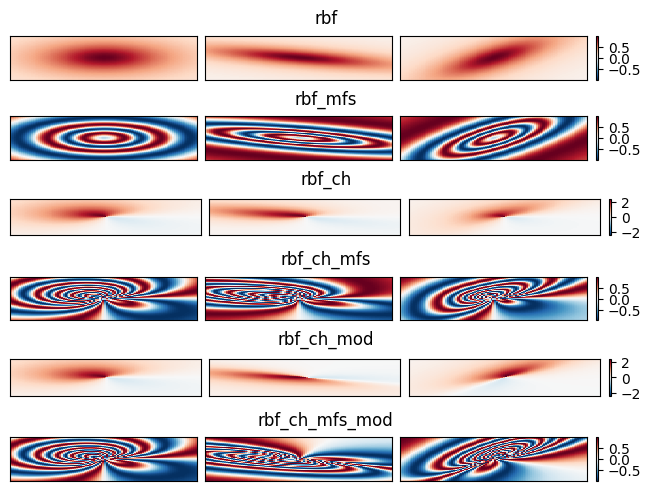

In [3]:
# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
xy = np.stack([x, y], axis=-1)

n_row = 6
n_col = 3
fig = plt.figure(constrained_layout=True)
subfigs = fig.subfigures(n_row, 1)
for row, subfig in enumerate(subfigs):
    func = func_params[row % n_row]
    subfig.suptitle(func)
    axes = subfig.subplots(nrows=1, ncols=n_col)
    for col, ax in enumerate(axes):
        idx = (row * n_col + col) % n_plot
        kc = c_params[idx]
        kcov = cov_params[idx]
        
        if func == 'rbf':
            z, _ = rbf(xy, kc[None, None, :], kcov[None, None, :, :])
        elif func == 'rbf_mfs':
            freq = freq_params[idx]
            z, _ = rbf(xy, kc[None, None, :], kcov[None, None, :, :])
            z = np.sin(z * freq)
        elif func == 'rbf_ch':
            ks = s_params[idx]
            kch = ch_params[idx]
            z, _ = rbf_ch(xy, kc[None, None, :], kcov[None, None, :, :], kch[None, None, :])
        elif func == 'rbf_ch_mfs':
            ks = s_params[idx]
            kch = ch_params[idx]
            freq = freq_params[idx]
            z, _ = rbf_ch(xy, kc[None, None, :], kcov[None, None, :, :], kch[None, None, :])
            z = np.sin(z * freq)
        elif func == 'rbf_ch_mod':
            ks = s_params[idx]
            kch = ch_params[idx]
            z, _ = rbf_ch_mod(xy, kc[None, None, :], kcov[None, None, :, :], kch[None, None, :], ks[None, None, :, :])
        elif func == 'rbf_ch_mfs_mod':
            ks = s_params[idx]
            kch = ch_params[idx]
            freq = freq_params[idx]
            z, _ = rbf_ch_mod(xy, kc[None, None, :], kcov[None, None, :, :], kch[None, None, :], ks[None, None, :, :])
            z = np.sin(z * freq)
        else:
            raise NotImplementedError
            
        # x and y are bounds, so z should be the value *inside* those bounds.
        # Therefore, remove the last value from the z array.
        z = z[:-1, :-1]
        z_min, z_max = -np.abs(z).max(), np.abs(z).max()
        
        c = ax.pcolormesh(x, y, z, cmap='RdBu_r', vmin=z_min, vmax=z_max)
        # set the limits of the plot to the limits of the data
        #ax.axis([x.min(), x.max(), y.min(), y.max()])
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
        if col == n_col -1:
            fig.colorbar(c, ax=ax)

plt.show()